In [5]:
import os
import pandas as pd

import re
import string
import requests
from bs4 import BeautifulSoup
from bs4.diagnose import diagnose

from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline


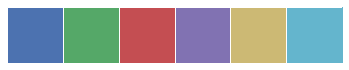

In [6]:
import seaborn as sns

plt.style.use('seaborn-notebook')

sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set(font_scale=2)
sns.set(color_codes=True)
sns.set(rc={'figure.figsize': (6.0, 4.0), 
            'xtick.labelsize': 16, 
            'ytick.labelsize': 16,
            'axes.labelweight': 'bold',
            'legend.fontsize': 16,
            'axes.labelsize': 16,
           'axes.titlesize': 20,
           'axes.titleweight': 'bold'})

current_palette = sns.color_palette()
sns.palplot(current_palette)


In [7]:
def get_text(url):
    '''scrapes debate transcript from a New York Times website'''
    data=""
    p=requests.get(url).content
    soup=BeautifulSoup(p,'lxml')    
    paragraphs=soup.select("p.story-body-text.story-content")
    data=p
    text=""
    for paragraph in paragraphs:
        text+=paragraph.text
    text=text.encode('ascii', 'ignore')
    return str(text)

In [8]:
debate2 = get_text('http://www.nytimes.com/2016/10/10/us/politics/transcript-second-debate.html')
debate1 = get_text('http://www.nytimes.com/2016/09/27/us/politics/transcript-debate.html')

In [9]:
def match_speakers(debate):
    '''returns a list of speaker names based on debate'''
    speakers2    = ['Trump', 'Clinton','Cooper','Raddatz']
    speakers1    = ['Trump', 'Clinton','Holt']

    if debate == debate1:
        return speakers1
    elif debate == debate2:
        return speakers2

In [10]:
def times_spoken_per_debate(debate):
    '''for a debate path and list of speakers returns the times a person spoke'''
    candidate_times = {}
    speakers = match_speakers(debate)
    #read transcript
    for s in speakers:
        s = s.upper() + ':'
        count = len(re.findall(s,debate))
        candidate_times[s.capitalize().strip(':')] = count
    if debate == debate1:
        candidate_times['Moderators'] = candidate_times['Holt']
    else: 
        candidate_times['Moderators'] = candidate_times['Raddatz'] + candidate_times['Cooper']
    return candidate_times


In [11]:
print 'Interjections in 1st debate'
print times_spoken_per_debate(debate1)
print 'Interjections in 2nd debate'
print times_spoken_per_debate(debate2)

Interjections in 1st debate
{'Moderators': 97, 'Holt': 97, 'Clinton': 94, 'Trump': 129}
Interjections in 2nd debate
{'Cooper': 75, 'Moderators': 136, 'Clinton': 61, 'Trump': 92, 'Raddatz': 61}


In [12]:
def plot_interjections(debate):
    df = pd.DataFrame.from_dict(times_spoken_per_debate(debate), orient='index')
    if debate == debate1:
        title = 'Interjections in First Debate'
    else:
        title = 'Interjections in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump','Moderators']
    print 'percent that Trump interjected more than Clinton'
    print (df.loc['Trump'] -df.loc['Clinton'])  / df.loc['Clinton']   
    df = df.loc[names_of_interest]
    #df.plot(kind='bar',title = title,legend = False)
    
    ax =  df.plot(kind='bar',title = title,legend = False)
    plt.xticks(rotation=0)
    #ax = df.plot()
    fig = ax.get_figure()
    fig.savefig(title + '.png')
    return fig

percent that Trump interjected more than Clinton
Interjections    0.37234
dtype: float64
percent that Trump interjected more than Clinton
Interjections    0.508197
dtype: float64


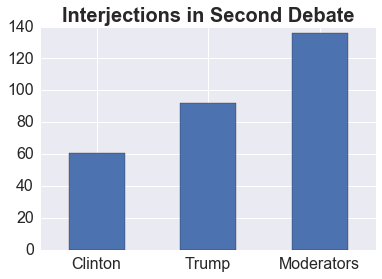

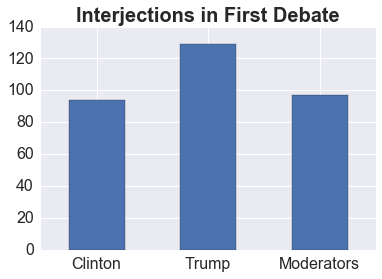

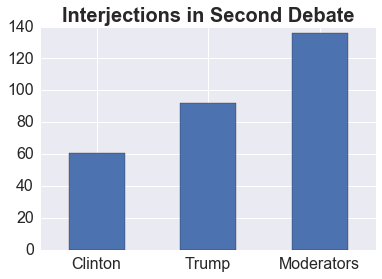

In [13]:
plot_interjections(debate1)#.plot(ax=axs[0],kind = 'bar',title = 'Interjections in First Debate',legend=False)
plot_interjections(debate2)#.plot(ax=axs[1],kind = 'bar',title = 'Interjections in Second Debate',legend=False)


In [16]:
def create_dict_of_debate(debate):
    '''return a dict by speaker of a debate transcript'''
    debate_dict = {}
    speakers = match_speakers(debate)
    for x in speakers:
        x = x.upper() + ':'
        debate_text = debate.replace('(APPLAUSE)','')
        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)
        #remove Holt intro, the 2nd debate transcript excludes the intro
        if x == 'HOLT:':
            all = all[1:]
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    return debate_dict



In [17]:
def create_dict_of_start_of_debate(debate_text,start,end):
    debate_dict = {}
    speakers = match_speakers(debate)
    for x in speakers:
        x = x.upper() + ':'
        debate_text = debate_text.replace('(APPLAUSE)','')
        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)
        #remove Holt intro, the 2nd debate transcript excludes the intro
        if x == 'HOLT:':
            all = all[1:]
        all = all[start:end]    
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    return debate_dict


In [18]:

def create_dict_of_periods_of_debate(debate,period,total_periods):
    '''divides a debate into periods and returns a dictionary of text from each each speaker'''
    debate_dict = {}
    debate_text = debate.replace('(APPLAUSE)','')
    speakers = match_speakers(debate)
    period = period - 1
    chunk_size = int(len(debate_text) / total_periods)
    i = period * chunk_size
    debate_text = debate1[i: i + chunk_size]

    for x in speakers:
        x = x.upper() + ':'

        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)

        
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    if debate_dict:
        return debate_dict


In [19]:
def convert_dict_to_df(a_dict):
    '''converts a dictionary to a dataframe'''
    debate_df = pd.DataFrame.from_dict(a_dict,orient='index', dtype=None)
    debate_df.rename(columns={0: "text"},inplace = True)
    return debate_df
                 

## Examine Wod Count

In [39]:
debate_dict = create_dict_of_debate(debate1)
for key, value in debate_dict.iteritems():
    print key,':',len(value.split(" "))


trump_words = len(debate_dict['Trump'].split(" "))
clinton_words = len(debate_dict['Clinton'].split(" "))
(trump_words - clinton_words) / clinton_words
(trump_words - clinton_words) 

Holt : 1648
Clinton : 4457
Trump : 6212


1755

In [40]:
debate_dict = create_dict_of_debate(debate2)
for key, value in debate_dict.iteritems():
    print key,':',len(value.split(" "))


trump_words = len(debate_dict['Trump'].split(" "))
clinton_words = len(debate_dict['Clinton'].split(" "))
(trump_words - clinton_words) / clinton_words

Cooper : 1051
Clinton : 5230
Trump : 5330
Raddatz : 1068


0.019120458891013385

In [55]:
def plot_word_count(debate):
    '''given a debate text, plots words spoken by each candidate in each debate'''
    debate_dict = create_dict_of_debate(debate)
    words_spoken_per_debate = {}
    for key, value in debate_dict.iteritems():
        words_spoken_per_debate[key] = len(value.split(" "))
        
    df = pd.DataFrame.from_dict(words_spoken_per_debate, orient='index')
    if debate == debate1:
        title = 'Words Spoken in First Debate'
    else:
        title = 'Words Spoken in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump']
    df = df.loc[names_of_interest]
   
    
    df.plot(kind='bar',title = title,legend = False)
    plt.xticks(rotation=0)

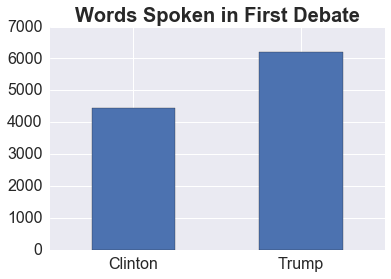

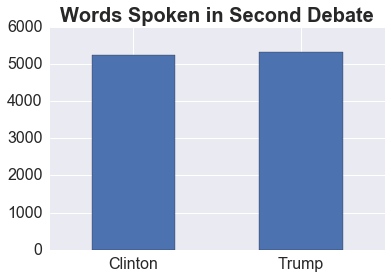

In [56]:
plot_word_count(debate1)
plt.savefig('debate1_words' + '.png')
plot_word_count(debate2)
plt.savefig('debate1_words' + '.png')


#fig.savefig('debate2_words' + '.png')

In [57]:
def plot_narcissim_index(debate):
    '''given a debate text, plots the narcissim index of each candidate'''
    debate_dict = create_dict_of_debate(debate)
    words_spoken_per_debate = {}
    for key, value in debate_dict.iteritems():
        words_spoken = len(value.split(" "))
        narcissism_count = 0
        for word in value.split(" "):
            if word in ['I',"I'm",'me','mine']:
                narcissism_count +=1
        words_spoken_per_debate[key] = narcissism_count / words_spoken
        
        
    df = pd.DataFrame.from_dict(words_spoken_per_debate, orient='index')
    if debate == debate1:
        title = '"Narcissism Index" \n Self Reference in First Debate'
    else:
        title = '"Narcissism Index" \n Self Reference in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump']
    df = df.loc[names_of_interest]
    df.plot(kind='bar',title = title,legend = False).set(xlabel='Self Referential Terms ("I","I\'m","me","mine","my","My")')
    
    plt.xticks(rotation=0)

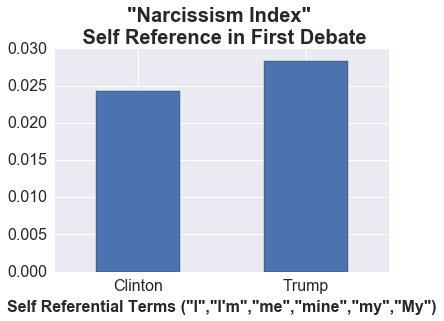

In [615]:
plot_narcissim_index(debate1)

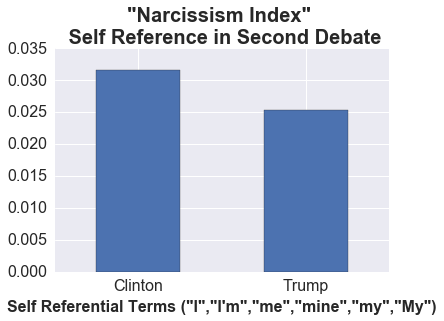

In [603]:
plot_narcissim_index(debate2)

In [60]:
def generate_wordcloud(df,debate):
    '''Generates wordcloud files'''
    speakers = match_speakers(debate)
    for p in speakers:
        print("Generating: %s" % p)
        wordcloud_filename = p.lower() + '1.png'
        wordcloud = WordCloud( max_words=500, width=900, height=600, background_color='white')
        text    =  df[df.index == p]['text'].get_values()[0]
        blob    = TextBlob(text)
        nouns   = [ word for word, pos in blob.tags if pos == 'NN' ]

        wordcloud.generate(' '.join(nouns))
        wordcloud.to_file(wordcloud_filename)
        image = wordcloud.to_image()
        
        #matplotlib.pyplot.imshow(image)
        fig = plt.figure()
        fig.suptitle(p, fontsize=14, fontweight='bold')
        plt.imshow(image)
    
        ## take relative word frequencies into account, lower max_font_size
        #wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
    #plt.figure()
    #plt.imshow(wordcloud)
    #plt.axis("off")
    #plt.show()
speakers2    = ['Trump', 'Clinton','Cooper','Raddatz']
speakers1    = ['Trump', 'Clinton','Holt']

def plot_wordclouds(debate):
    debate_dict = create_dict_of_debate(debate)
    df = convert_dict_to_df(debate_dict)
    generate_wordcloud(df,debate)



Generating: Trump
Generating: Clinton
Generating: Holt


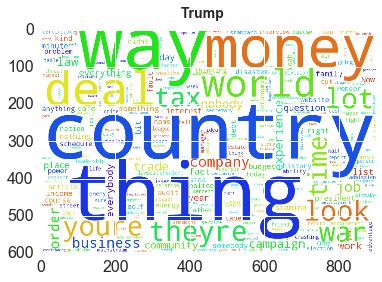

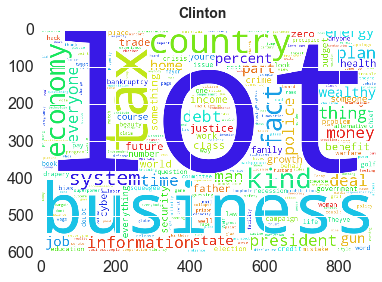

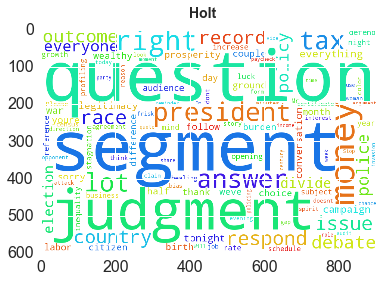

In [59]:
plot_wordclouds(debate1)


Generating: Trump
Generating: Clinton
Generating: Cooper
Generating: Raddatz


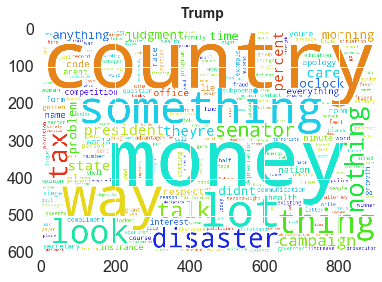

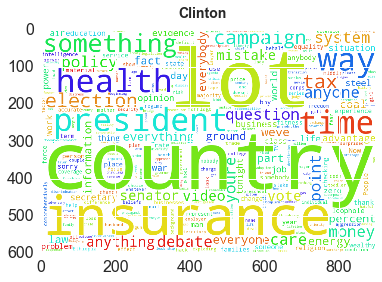

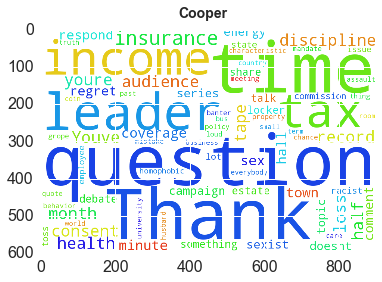

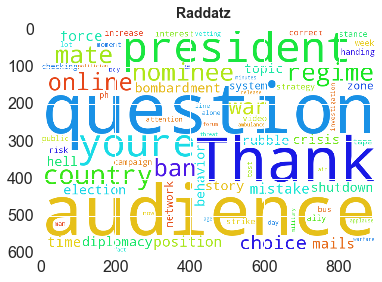

In [608]:
plot_wordclouds(debate2)

In [292]:
def print_sentiment_analysis(speakers,debate,start,end):
    debate_dict = create_dict_of_start_of_debate(speakers,debate,start,end)
    for key, value in debate_dict.iteritems():
        if key == 'Clinton' or key == 'Trump':
            print key
            transcript = TextBlob(value)
            #print transcript.sentiment
            print transcript.sentiment.polarity


In [367]:
def get_sentiment_analysis(speaker,debate,period,total_periods):
    debate_dict = create_dict_of_periods_of_debate(debate,period,total_periods)
    #print debate_dict
    transcript = TextBlob(debate_dict[speaker])
    n =  transcript.sentiment.polarity
    return round(n,3)
    

In [368]:
get_sentiment_analysis('Clinton',debate1,2,8)

0.211

In [369]:
def create_dataframe_of_sentiment(debate,total_periods):
    # create index
    time_periods = [x for x in xrange(1,(total_periods+1))]
    df = pd.DataFrame(index= time_periods)
    df['Clinton'] = [get_sentiment_analysis('Clinton',debate,x,total_periods) for x in xrange(1,(total_periods+1))]
    df['Trump'] = [get_sentiment_analysis('Trump',debate,x,total_periods) for x in xrange(1,(total_periods+1))]
    #df[speaker] = get_sentiment_analysis(speaker,debate,period,total_periods)
    return df
    #for x in
    

In [90]:
winnebego_text = u'''The Winnebago concept on engineering department has developed the multi functional bathroom, privacy I don't know what the fuck I'm reading. I wonder what the fuck the real dialogue is. What the fuck is this thing? Under the windshield for fucks say. Oh fuck. What the fuck did I say? That didn't' sound for shit did it? Trying to give these guys everything they can get from me. That's it, fuck it. I don't know that the fuck I'm saying. How do you suppose we open. Got to do it again right now. Oh fuck! Fuck! Fuck! Fuck! Shit! Tony do me a favor please. Will you do me a kindness? It doesn't make a difference to me at this juncture. Thank you very much I appreciate that Tony. Don't slam the fucking door. No more! Listen I got to give a clue here now. I don't want any more bullshit any time during the day from anyone that includes me. It's going to be very hot, very uncomfortable for everybody. I don't want anybody yelling. We get anybody yelling around here anymore today and then the shit is going to hit the fan. They may fit the needs of a very diverse buyer's segment. Why can't I remember it! I wrote this stuff, why can't I remember it. Why don't I say it fucking right? What is the god damn line say? What is the god damn line? I don't give a shit what the line is. I fucked up the word rear. I can't even read the VO straight. What the fuck was that. We got flies all over the fucking place. Son of a bitch, get out of here you fucking flies. There is a fly over the headlight Tony. We got flies coming for us, fuck. Get the fuck out of here you flies. We got 3 flies, 5 flies. Make sure if you will we don't have the fly on the left side of the passenger side but make sure we don't have any flies. Here we go. Get out of her you God damn jackass. I got to read it again because my mind is a piece of shit this morning. I can't make my mind work. Tony gives me a towel for a minute please. I'm blinded by that bucket of god damn son of a bitch. What do you mean, I'm about to fall off the fucking thing. Fuck, just keep running. Bull shit I'm going to slay this fucker. I haven't got time to mark this mother fucker. Here we go again, we can't hear anybody, no one can talk to anybody. Well turn the fucking thing off. You dumbass. I'd like to kick your fucking head in. Meet innovation, money fuck not even funny anymore. Son of a bitch! Jesus Christ. Fuck! Son of a bitch! Jesus Christ. Fuck! Shit! Son of a Bitch. Jesus Christ. Fuck! Shit! Son of a Bitch. Jesus Christ. Fuck! Shit! Son of a Bitch. Jesus Christ. Oh fuck off. What the hell is the line. I can't remember the line. It's just all gone. I get some god damn diuretic when I sit here and my mouth doesn't stop. Not this shit. The mini Winnie, part of American tradition and today the cutting edge of design and function in a Class C motor home. DO you belie any of that shit?'''.encode("utf8")

In [91]:
winnebego_text[1929:1940]

'bucket of g'

In [92]:
transcript = TextBlob(winnebego_text)
n =  transcript.sentiment.polarity

In [93]:
n

-0.1933503401360544

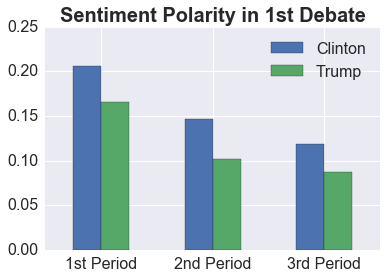

In [626]:
df = create_dataframe_of_sentiment(debate1,3)
ax = df.plot(kind = 'bar',title = 'Sentiment Polarity in 1st Debate')
#ax.set_xticks( [ 0.5, 1.5, 2.5 ] )
ax.set_xticklabels( ['1st Period','2nd Period','3rd Period'], rotation=45 ) 


plt.xticks(rotation=0)

#plt.set.xlabel='30 Minute Period of Debate'
fig = ax.get_figure()
fig.savefig('first' + '.png')

In [371]:
df

,Clinton,Trump
1,0.208,0.236
2,0.115,0.078
3,0.139,0.161
4,0.178,0.077


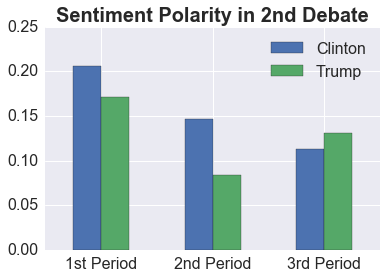

In [628]:
df2 = create_dataframe_of_sentiment(debate2,3)

ax = df2.plot(kind = 'bar',title = 'Sentiment Polarity in 2nd Debate')
ax.set_xticklabels( ['1st Period','2nd Period','3rd Period'], rotation=45 ) 


plt.xticks(rotation=0)

#plt.set.xlabel='30 Minute Period of Debate'
fig = ax.get_figure()
fig.savefig('second' + '.png')

In [197]:
sentiment_dict = {}
for x in xrange(1,8):
    print_sentiment_analysis(speakers1,debate1,x,8)

('Clinton', 0.2515603557440292)
('Trump', 0.2668064182194617)
('Clinton', 0.2106060606060606)
('Trump', 0.18603380746237888)
('Clinton', 0.0755952380952381)
('Trump', 0.08952075702075701)
('Clinton', 0.14716582491582494)
('Trump', 0.028912605787605808)
('Clinton', 0.17253340454639154)
('Trump', 0.10688353636028053)
('Clinton', 0.056953792735042745)
('Trump', 0.24146962233169136)
('Clinton', 0.16764069264069262)
('Trump', 0.14449098260573673)
